# Import Library

In [124]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
import math
import matplotlib as mpl
from sklearn.metrics import mean_squared_error

### Read Dataset

In [125]:
dataset = pd.read_csv('data/ICICIBANK.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,ICICIBANK,EQ,69.20,74.35,74.75,71.40,74.75,74.75,73.20,286260,2.095439e+12,NaN,NaN,NaN
2000-01-04,ICICIBANK,EQ,74.75,73.05,78.50,71.00,73.25,73.05,73.38,296264,2.173893e+12,NaN,NaN,NaN
2000-01-05,ICICIBANK,EQ,73.05,70.00,73.50,67.50,70.00,69.50,70.85,227624,1.612794e+12,NaN,NaN,NaN
2000-01-06,ICICIBANK,EQ,69.50,71.00,74.00,69.55,69.75,70.05,72.04,275149,1.982121e+12,NaN,NaN,NaN
2000-01-07,ICICIBANK,EQ,70.05,69.00,72.50,66.00,67.00,67.40,68.72,138809,9.538882e+11,NaN,NaN,NaN


In [126]:
dataset.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5.306000e+03,5.306000e+03,2456.000000,4.789000e+03,4789.000000
mean,550.895392,551.558538,560.558556,541.534197,551.050980,550.995524,551.129031,8.224631e+06,3.759336e+14,138367.627443,4.183406e+06,0.473463
std,368.784064,368.890953,374.079697,363.389664,368.705647,368.725374,368.746905,1.218535e+07,4.759238e+14,99008.729009,6.365382e+06,0.131495
min,67.400000,67.000000,70.450000,66.000000,67.000000,67.400000,68.520000,7.409000e+03,9.617283e+10,2595.000000,1.501500e+04,0.099000
25%,267.562500,267.400000,271.912500,263.625000,267.400000,267.612500,267.577500,9.612055e+05,3.459444e+13,79312.250000,6.995020e+05,0.384300
50%,398.075000,399.000000,406.525000,392.450000,398.700000,398.175000,398.235000,3.486648e+06,2.923010e+14,110101.000000,1.963117e+06,0.476400
75%,873.562500,877.000000,888.775000,859.800000,874.600000,873.562500,873.510000,1.157202e+07,4.993528e+14,162953.500000,5.948817e+06,0.564100
max,1794.100000,1767.050000,1798.150000,1760.150000,1793.000000,1794.100000,1783.460000,2.868577e+08,1.461959e+16,949891.000000,2.325307e+08,0.983000


In [127]:
dataset.isnull().sum()

Symbol                   0
Series                   0
Prev Close               0
Open                     0
High                     0
Low                      0
Last                     0
Close                    0
VWAP                     0
Volume                   0
Turnover                 0
Trades                2850
Deliverable Volume     517
%Deliverble            517
dtype: int64

### Mengambil kolom tertentu saja pada dataset

In [128]:
df = dataset[[ 'Prev Close', 'High', 'Low', 'Last', 'Close', 'VWAP', 'Volume']].copy()

In [129]:
df.head()

,Prev Close,High,Low,Last,Close,VWAP,Volume
Date,,,,,,,
2000-01-03,69.20,74.75,71.40,74.75,74.75,73.20,286260
2000-01-04,74.75,78.50,71.00,73.25,73.05,73.38,296264
2000-01-05,73.05,73.50,67.50,70.00,69.50,70.85,227624
2000-01-06,69.50,74.00,69.55,69.75,70.05,72.04,275149
2000-01-07,70.05,72.50,66.00,67.00,67.40,68.72,138809


# Data Preprocessing

### Reshape Data menjadi Array 2D

In [130]:
df.shape

(5306, 7)

In [131]:
# Mengambil kolom VWAP dan mengubahnya menjadi array 2D
df_2d = df['VWAP'].values.reshape(5306,1)
print(df_2d.shape)
print(df_2d)

(5306, 1)
[[ 73.2 ]
 [ 73.38]
 [ 70.85]
 ...
 [612.57]
 [619.55]
 [607.02]]


### Scaling Data

In [132]:
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
df_2d = scaler.fit_transform(df_2d)

### Splitting Train dan Test Set

In [133]:
train_size = int(len(df_2d) * 0.7)
test_size = len(df_2d) - train_size
train, test = df_2d[0:train_size,:], df_2d[train_size:len(df_2d),:]
print(train.shape)
print(test.shape)

(3714, 1)
(1592, 1)


### Membuat Sequence

In [134]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        # print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [135]:
train.shape

(3714, 1)

In [136]:
test.shape

(1592, 1)

In [137]:
seq_size = 100

X_train, y_train = to_sequences(train, seq_size)
X_test, y_test = to_sequences(test, seq_size)

print("Shape of training set: {}".format(X_train.shape))
print("Shape of test set: {}".format(X_test.shape))

Shape of training set: (3613, 100)
Shape of test set: (1491, 100)


### Mengubah Data Train dan Test menjadi 3D

In [138]:
#Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train)
print(X_train.shape)

[[[2.72895845e-03]
  [2.83391839e-03]
  [1.35864812e-03]
  ...
  [8.21486466e-02]
  [8.04284698e-02]
  [8.18162735e-02]]

 [[2.83391839e-03]
  [1.35864812e-03]
  [2.05254994e-03]
  ...
  [8.04284698e-02]
  [8.18162735e-02]
  [8.19853756e-02]]

 [[1.35864812e-03]
  [2.05254994e-03]
  [1.16622156e-04]
  ...
  [8.18162735e-02]
  [8.19853756e-02]
  [8.41487166e-02]]

 ...

 [[7.96511831e-01]
  [7.85176158e-01]
  [7.81881582e-01]
  ...
  [9.46388795e-01]
  [9.34901513e-01]
  [9.39741332e-01]]

 [[7.85176158e-01]
  [7.81881582e-01]
  [7.82301422e-01]
  ...
  [9.34901513e-01]
  [9.39741332e-01]
  [9.43274983e-01]]

 [[7.81881582e-01]
  [7.82301422e-01]
  [7.97159084e-01]
  ...
  [9.39741332e-01]
  [9.43274983e-01]
  [9.41181616e-01]]]
(3613, 100, 1)


# Import Model yang sudah ditraining

In [139]:
from keras.models import load_model

In [143]:
model = load_model('./rnn_model_100seq.h5')

### Memprediksi Model Train dan Test

In [144]:
def plot_predictions(title, test,predicted):
    plt.figure(figsize = (20,10))
    plt.plot(test, color='red',label='Actual')
    plt.plot(predicted, color='blue',label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [145]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [146]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])

In [147]:
# calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score: %.2f RMSE' % (testScore))

Score: 10.01 RMSE


In [148]:
# plot_predictions('ICICIBANK Stock Price Prediction - Train Data', trainY[0], trainPredict[:,0])

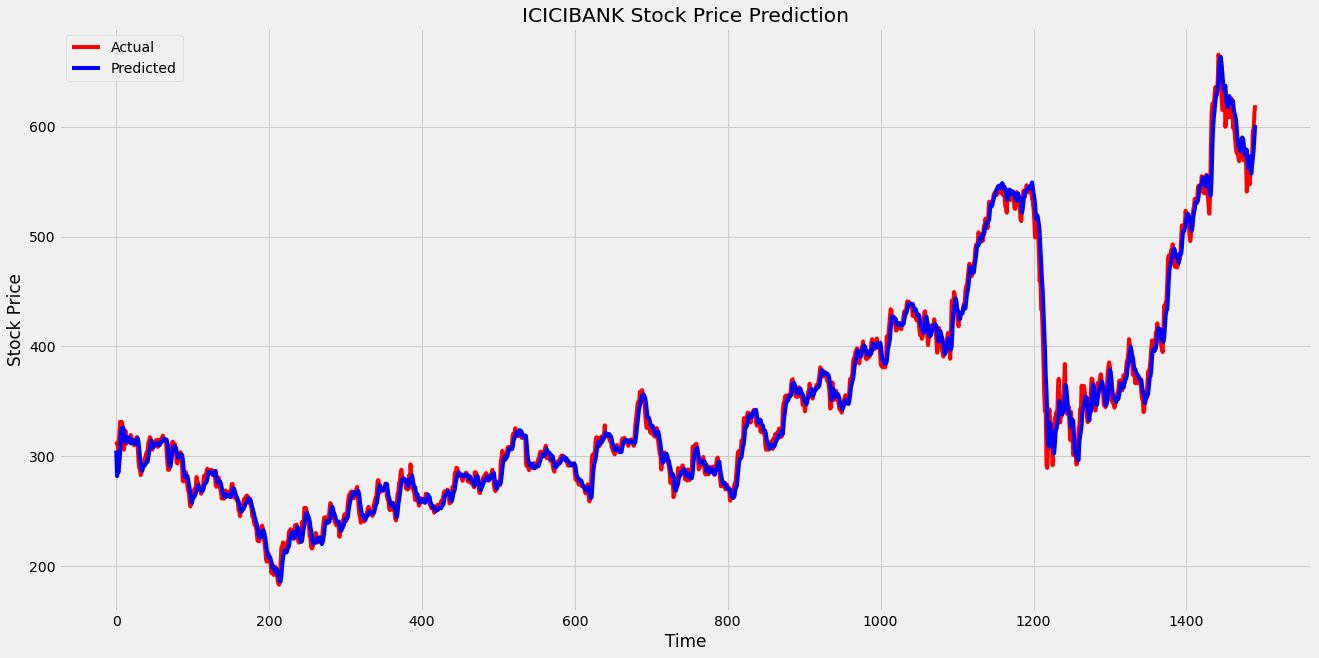

In [149]:
plot_predictions('ICICIBANK Stock Price Prediction', testY[0], testPredict[:,0])

# Prediksi 13 dan 15 Tahun Kedepan

In [150]:
len(test)

1592

In [151]:
test.shape

(1592, 1)

### Membuat Sequence 100 hari terakhir

In [152]:
last_day = seq_size

In [153]:
#Getting the last 100 days records
fut_inp = test[len(test)-last_day:]
fut_inp = fut_inp.reshape(1,-1)


In [154]:
tmp_inp = list(fut_inp)

In [155]:
fut_inp.shape

(1, 100)

In [156]:
# Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [157]:
# Hari berikutnya yang akan diprediksi
# 15 tahun
next_a = 13 * 360
next_b = 15 * 360
print("13 Tahun kedepan : {} hari".format(next_a))
print("15 Tahun kedepan : {} hari".format(next_b))

13 Tahun kedepan : 4680 hari
15 Tahun kedepan : 5400 hari


In [158]:
next_day = next_b

In [159]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps= last_day
i=0
while(i<next_day):
    
    if(len(tmp_inp)>last_day):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

# print(lst_output)

In [160]:
len(df_2d)

5306

In [161]:
df_2d

array([[0.00272896],
       [0.00283392],
       [0.00135865],
       ...,
       [0.31724142],
       [0.32131153],
       [0.31400515]])

In [162]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,last_day+1)
plot_pred=np.arange(last_day+1,last_day+1+next_day)

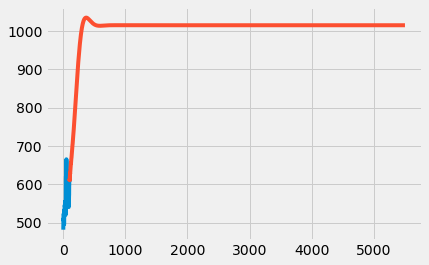

In [163]:
plt.plot(plot_new, scaler.inverse_transform(df_2d[len(df_2d)-last_day:]))
plt.plot(plot_pred, scaler.inverse_transform(lst_output))

In [164]:
future_predict = scaler.inverse_transform(lst_output)
future_predict.shape

(5400, 1)

In [165]:
print("Harga saham pada 13 tahun ke depan ({} hari) : {}".format(next_a, future_predict[next_a-1]))
print("Harga saham pada 15 tahun ke depan ({} hari): {}".format(next_b, future_predict[next_b-1]))

Harga saham pada 13 tahun ke depan (4680 hari) : [1015.11073839]
Harga saham pada 15 tahun ke depan (5400 hari): [1015.11053395]


In [166]:
plot_pred1=np.arange(last_day+1,last_day+1+60)

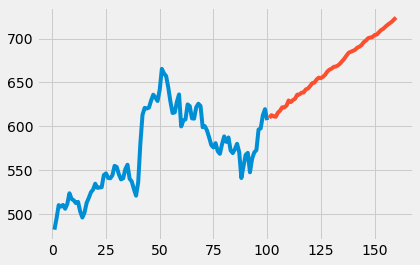

In [167]:
plt.plot(plot_new, scaler.inverse_transform(df_2d[len(df_2d)-last_day:]))
plt.plot(plot_pred1, scaler.inverse_transform(lst_output[:60]))

In [168]:
print("Harga saham pada 30 hari ke depan : {}".format(future_predict[30-1]))
print("Harga saham pada 60 hari ke depan : {}".format(future_predict[60-1]))

Harga saham pada 30 hari ke depan : [665.76211733]
Harga saham pada 60 hari ke depan : [724.03569679]


# Final Data

In [169]:
test_new = test.tolist()

In [170]:
len(test_new)

1592

In [171]:
# Join test data dengan predicted future output
test_new.extend(lst_output)

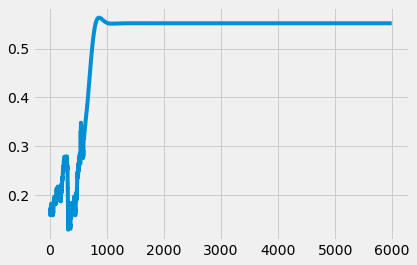

In [172]:

plt.plot(test_new[1000:])

In [173]:
# Membuat graph final
final_graph = scaler.inverse_transform(test_new).tolist()

In [174]:
len(final_graph)

6992

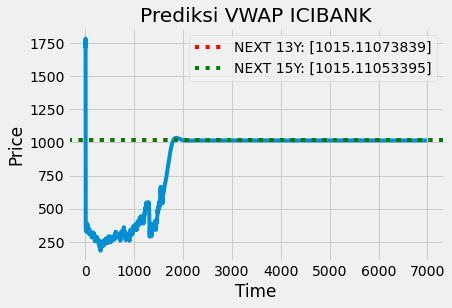

In [175]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("Prediksi VWAP ICIBANK")
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 13Y: {0}'.format(future_predict[next_a-1]))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'green', linestyle = 'dotted', label = 'NEXT 15Y: {0}'.format(future_predict[next_b-1]))
plt.legend()